In [1]:
from tensorflow.keras.applications.vgg16 import VGG16,preprocess_input
from keras.models import Model
import os
import cv2
import random
import glob
import pickle
from tqdm.notebook import tqdm
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np

In [2]:
from google.colab import files
files.upload()
! mkdir ~/.kaggle

Saving kaggle.json to kaggle.json


In [3]:
! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [11]:
!kaggle datasets download -d adityajn105/flickr8k

Dataset URL: https://www.kaggle.com/datasets/adityajn105/flickr8k
License(s): CC0-1.0
 99% 1.03G/1.04G [00:08<00:00, 182MB/s]
100% 1.04G/1.04G [00:08<00:00, 128MB/s]


In [12]:
!mkdir flickr8k

mkdir: cannot create directory ‘flickr8k’: File exists


In [13]:
!unzip flickr8k.zip -d flickr8k

Streaming output truncated to the last 5000 lines.
  inflating: flickr8k/Images/2844846111_8c1cbfc75d.jpg  
  inflating: flickr8k/Images/2844963839_ff09cdb81f.jpg  
  inflating: flickr8k/Images/2845246160_d0d1bbd6f0.jpg  
  inflating: flickr8k/Images/2845691057_d4ab89d889.jpg  
  inflating: flickr8k/Images/2845845721_d0bc113ff7.jpg  
  inflating: flickr8k/Images/2846037553_1a1de50709.jpg  
  inflating: flickr8k/Images/2846785268_904c5fcf9f.jpg  
  inflating: flickr8k/Images/2846843520_b0e6211478.jpg  
  inflating: flickr8k/Images/2847514745_9a35493023.jpg  
  inflating: flickr8k/Images/2847615962_c330bded6e.jpg  
  inflating: flickr8k/Images/2847859796_4d9cb0d31f.jpg  
  inflating: flickr8k/Images/2848266893_9693c66275.jpg  
  inflating: flickr8k/Images/2848571082_26454cb981.jpg  
  inflating: flickr8k/Images/2848895544_6d06210e9d.jpg  
  inflating: flickr8k/Images/2848977044_446a31d86e.jpg  
  inflating: flickr8k/Images/2849194983_2968c72832.jpg  
  inflating: flickr8k/Images/28507194

In [15]:
base_model=VGG16(weights="imagenet")
#we created our model using VGG16 without the last prediction layer
#Here we use Model to create our model, which is a non-linear wat to create nueral netwrk models
model=Model(inputs=base_model.inputs,outputs=base_model.layers[-2].output)
model.summary()

553467096/553467096 [==============================] - 7s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [17]:
#extracting
features={}
directory="/content/flickr8k/Images"
for img_name in tqdm(os.listdir(directory)):
      img_path=os.path.join(directory,img_name)

      image=load_img(img_path,target_size=(224,224))

      image=img_to_array(image)

      image=image.reshape(1,image.shape[0],image.shape[1],image.shape[2])

      feature=model.predict(image,verbose=0)

      image_id=img_name.split(".")[0]

      features[image_id]=feature

  0%|          | 0/8091 [00:00<?, ?it/s]

In [18]:
pickle.dump(features,open("features.pkl","wb"))#saving the features dictionary so that we can just load this later when we need it


In [19]:
with open("features.pkl","rb") as f:
  features=pickle.load(f)

In [20]:
with open("/content/flickr8k/captions.txt","r") as file:
  next(file)
  captions=file.read()

In [21]:
mapping={}
for line in tqdm(captions.split("\n")):

    tokens=line.split(",")
    if len(tokens)<2:
      continue
    else:
      image_id,image_caption=tokens[0],tokens[1:]

    image_id=image_id.split(".")[0]

    image_caption=" ".join(image_caption)

    if image_id not in mapping:
      mapping[image_id]=[]
    mapping[image_id].append(image_caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [22]:
import nltk
nltk.download("stopwords")
import re
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [23]:
def preprocessing(mapping):
  for id,captions in mapping.items():
    for i in range(len(captions)):
      caption=captions[i]

      #converts caption to lower case and removes leading and trailing white spaces
      caption=caption.lower().strip()

      #removing punctations and non-word characters
      pattern=re.compile("\W")
      caption=re.sub(pattern," ",caption)

      #for our model we need to add start and end tags.
      caption="startseq " + caption + " endseq"


      captions[i]=caption

In [24]:
preprocessing(mapping)

In [25]:
all_captions=[]
for key in mapping:
  for caption in mapping[key]:
    all_captions.append(caption)

In [26]:
from keras.preprocessing.text import Tokenizer

tokenizer=Tokenizer()
tokenizer.fit_on_texts(all_captions)
#This is the number of unique words in our vocabulary
vocab_size=len(tokenizer.word_index)+1

In [27]:
max_length = max(len(caption.split()) for caption in all_captions)
max_length

39

In [28]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np

In [29]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

In [30]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [31]:
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add


In [32]:
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [33]:
# train the model
epochs = 20
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

227/227 [==============================] - 66s 288ms/step - loss: 2.0311


In [34]:
model.save("best_model.h5")


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [35]:
def ind_to_word(ind,tokenizer):
    for word,index in tokenizer.word_index.items():
        if ind==index:
            return word

    return None

In [39]:
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = ind_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
    return in_text

In [60]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    image_id = image_name.split('.')[0]
    img_path = os.path.join("/content/flickr8k/Images", image_name)
    image = Image.open(img_path)
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

--------------------Predicted--------------------
startseq a man in a helmet participates in a curve in a busy park endseq


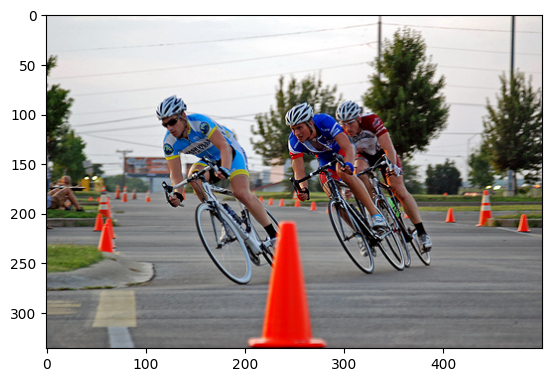

In [61]:
generate_caption("3704698586_a42c25d0c1.jpg")